# Vienna data cube
TODO Link to metadata (source data, a/p metadata)

## Connect to s3 bucket

In [16]:
import s3fs
import xarray as xr
import rioxarray as rxr
from configparser import ConfigParser
import os
def config(filename, section='s3'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
    # get section, default to postgresql
    s3 = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            s3[param[0]] = param[1]
    else:
        raise KeyError(
            f'Section {section} not found in {filename}. Did you specifiy the right path?')
    return s3


try:
    s3_config = config('../../database.ini')
   
except KeyError as er:
    print(er)
    print('Config file not found or malformed, trying with environment variables...')
    if (os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET') is None):
        print('environment variables not set, contact the admin')
    else:
        s3_config = {
            's3_fairicube_storage_bucket': os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET'),
            's3_fairicube_storage_key': os.environ.get('S3_FAIRICUBE_STORAGE_KEY'),
            's3_fairicube_storage_secret': os.environ.get('S3_FAIRICUBE_STORAGE_SECRET')}


In [17]:
s3fs_FS = s3fs.S3FileSystem(
    key=s3_config['s3_fairicube_storage_key'],
    secret=s3_config['s3_fairicube_storage_secret'],
)

## List cube dimensions

In [19]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
#https://stacapi.eoxhub.fairicube.eu/api

# List all files in the folder
files = s3fs_FS.ls('s3:///fairicube/vienna_data/100m/')

# Print the list of files
for file in files:
    print(file)

fairicube/vienna_data/100m/
fairicube/vienna_data/100m/RR_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/RR_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/SA_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/SA_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TN_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TN_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TX_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TX_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/r00_admin_districts
fairicube/vienna_data/100m/r01_landuse
fairicube/vienna_data/100m/r02_dem
fairicube/vienna_data/100m/r03_biotones
fairicube/vienna_data/100m/r04_imp
fairicube/vienna_data/100m/r05_treecover
fairicube/vienna_data/100m/r06_protected_area
fairicube/vienna_data/100m/r07_water


## Load dimensions
### Spatiotemporal cube

In [264]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
# spatiotemporal cube - max daily 2m temperature
s3map = s3fs.S3Map(root='s3:///fairicube/vienna_data/100m/TN_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr', s3=s3fs_FS)
ds = xr.open_zarr(store=s3map)

In [265]:
ds

<xarray.Dataset>
Dimensions:                  (time: 1583, y: 230, x: 300)
Coordinates:
  * time                     (time) datetime64[ns] 2020-01-01 ... 2024-05-01
  * x                        (x) float64 -1.115e+04 -1.105e+04 ... 1.875e+04
  * y                        (y) float64 3.54e+05 3.538e+05 ... 3.31e+05
Data variables:
    TN                       (time, y, x) float64 dask.array<chunksize=(198, 29, 75), meta=np.ndarray>
    lambert_conformal_conic  int32 ...
Attributes:
    author:   space4environment sàrl for FAIRiCUBE
    history:  Original data produced by GeoSphere Austria and updated daily. ...

### Thematic spatial cube

In [191]:
# land use
import pandas as pd
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/r01_real_land_use2020_100m_b32_1_1.tif'))
# convert bands into data variables
ds_landuse = xr.merge([da[band].to_dataset(name=f'land_use{band+1}') for band in range(0,32)], compat='override')
ds_landuse

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
    band         int32 1
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables: (12/32)
    land_use1    (y, x) float32 ...
    land_use2    (y, x) float32 ...
    land_use3    (y, x) float32 ...
    land_use4    (y, x) float32 ...
    land_use5    (y, x) float32 ...
    land_use6    (y, x) float32 ...
    ...           ...
    land_use27   (y, x) float32 ...
    land_use28   (y, x) float32 ...
    land_use29   (y, x) float32 ...
    land_use30   (y, x) float32 ...
    land_use31   (y, x) float32 ...
    land_use32   (y, x) float32 ...

### Rename data variable names

In [263]:
# read LookUpTable (lut)
lut_land_use =pd.read_csv(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/lut_realnutzung.csv'))
#lut_land_use


#update Data variables:
# List variables
variable_list = list(ds_landuse.keys()) 
for variable_in_list in variable_list:

    # print (variable_in_list)
    band_numer = int(variable_in_list.split("land_use",1)[1])
    # print ((band_numer))
    # set the index to be the names column
    
    result_row=lut_land_use[lut_land_use['NUTZUNG_CODE'] == band_numer]#.reset_index
    cell_value = result_row['NUTZUNG_L1'].values[0]
    print (band_numer, cell_value)
    ds_landuse=ds_landuse.rename(name_dict={variable_in_list:cell_value})



IndexError: list index out of range

In [194]:
ds_landuse

<xarray.Dataset>
Dimensions:                                            (x: 300, y: 230)
Coordinates:
    band                                               int32 1
  * x                                                  (x) float64 -1.115e+04...
  * y                                                  (y) float64 3.54e+05 ....
    spatial_ref                                        int32 0
Data variables: (12/32)
    locker bebautes Wohn(misch)gebiet                  (y, x) float32 ...
    Wohn(misch)gebiet mittlerer Dichte                 (y, x) float32 ...
    dichtes Wohn(misch)gebiet                          (y, x) float32 ...
    grossvolumiger, solidaerer Wohn(misch)bau          (y, x) float32 ...
    Buero- und Verwaltungsviertel                      (y, x) float32 ...
    solitaere Handelsstrukturen                        (y, x) float32 ...
    ...                                                 ...
    Acker                                              (y, x) float32 ...
    Weingarten                                         (y, x) float32 ...
    Gaertnerei, Obstplantagen                          (y, x) float32 ...
    Wald                                               (y, x) float32 ...
    Wiese                                              (y, x) float32 ...
    Gewaeser inkl. Bachbett                            (y, x) float32 ...

Map the land use "Park, Gruenanlage"

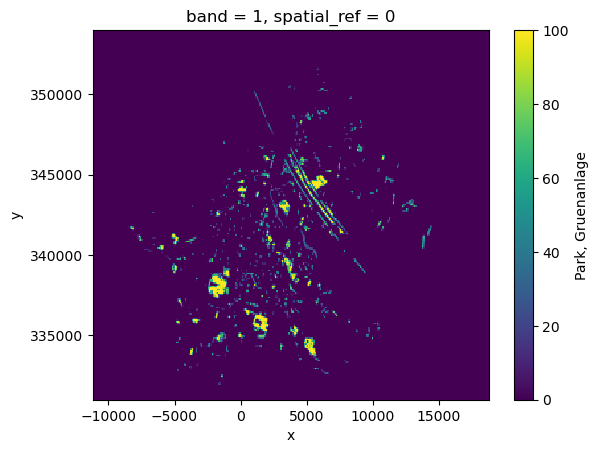

In [195]:
green_area = ds_landuse.get("Park, Gruenanlage")

#green_area_sum_area = green_area.sum()
green_area.plot()

What is the total area?

In [196]:
#print(green_area.sum(dim=['x','y']))
print ("total area [ha]")
print(green_area.values.sum() /100)

total area [ha]
1228.07


### Load next dimension

In [197]:
# digital elevation model
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r02_dem/r02_dem_mean_100m_b1_1_1.tif'))
ds_dem = da.drop_vars('band').squeeze().to_dataset(name='dem')
ds_dem

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables:
    dem          (y, x) float32 ...

In [198]:
# merge into one cube
cube = xr.merge([ds_landuse, ds_dem])
cube

<xarray.Dataset>
Dimensions:                                            (x: 300, y: 230)
Coordinates:
    band                                               int32 1
  * x                                                  (x) float64 -1.115e+04...
  * y                                                  (y) float64 3.54e+05 ....
    spatial_ref                                        int32 0
Data variables: (12/33)
    locker bebautes Wohn(misch)gebiet                  (y, x) float32 ...
    Wohn(misch)gebiet mittlerer Dichte                 (y, x) float32 ...
    dichtes Wohn(misch)gebiet                          (y, x) float32 ...
    grossvolumiger, solidaerer Wohn(misch)bau          (y, x) float32 ...
    Buero- und Verwaltungsviertel                      (y, x) float32 ...
    solitaere Handelsstrukturen                        (y, x) float32 ...
    ...                                                 ...
    Weingarten                                         (y, x) float32 ...
    Gaertnerei, Obstplantagen                          (y, x) float32 ...
    Wald                                               (y, x) float32 ...
    Wiese                                              (y, x) float32 ...
    Gewaeser inkl. Bachbett                            (y, x) float32 ...
    dem                                                (y, x) float32 ...

## Explore the cube
### Spatiotemporal cube

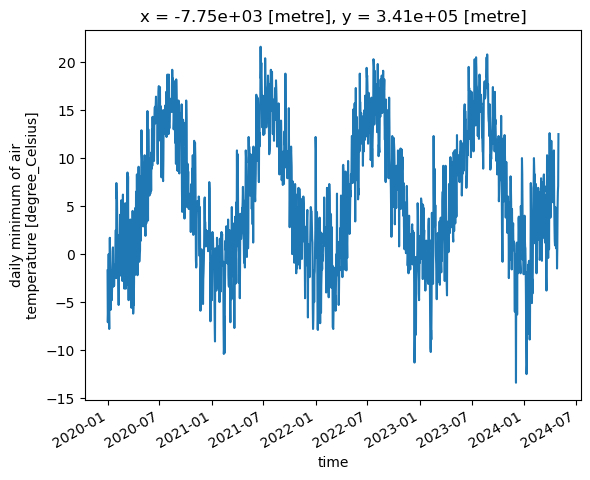

In [199]:
# spatiotemporal cube (2m max temperature)
# time series of one location
ds.TN.sel(x=-7700, y=341000, method='ffill').plot()

### Thematic spatial cube

#### Get values at location

In [150]:
# get all values at a single location, and convert to dataframe
cube.sel(x=-7700, y=341000, method='ffill').expand_dims('band').to_dataframe()

,x,y,spatial_ref,locker bebautes Wohn(misch)gebiet,Wohn(misch)gebiet mittlerer Dichte,dichtes Wohn(misch)gebiet,"grossvolumiger, solidaerer Wohn(misch)bau",Buero- und Verwaltungsviertel,solitaere Handelsstrukturen,"Geschaefts-, Kern- u. Mischgebiete",...,"Park, Gruenanlage","Sport und Bad (Outdoor), Camping",Friedhof,Acker,Weingarten,"Gaertnerei, Obstplantagen",Wald,Wiese,Gewaeser inkl. Bachbett,dem
band,,,,,,,,,,,,,,,,,,,,,
1,-7750.0,341050.0,0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,225.316086


In [274]:
# get all values at multiple locations, and convert to dataframe
x_coords = xr.DataArray([-950, 18550])
y_coords = xr.DataArray([341000, 331250])
cube.sel(x=x_coords, y=y_coords, method='ffill').expand_dims('band').to_dataframe()

x         y  spatial_ref  locker bebautes Wohn(misch)gebiet  \
band dim_0                                                                      
1    0       -950.0  341050.0            0                                0.0   
     1      18550.0  331250.0            0                                0.0   

            Wohn(misch)gebiet mittlerer Dichte  dichtes Wohn(misch)gebiet  \
band dim_0                                                                  
1    0                                     0.0                       56.0   
     1                                     0.0                        0.0   

            grossvolumiger, solidaerer Wohn(misch)bau  \
band dim_0                                              
1    0                                            0.0   
     1                                            0.0   

            Buero- und Verwaltungsviertel  solitaere Handelsstrukturen  \
band dim_0                                                               
1    0                                0.0                          0.0   
     1                                0.0                          0.0   

            Geschaefts-, Kern- u. Mischgebiete  ...  Park, Gruenanlage  \
band dim_0                                      ...                      
1    0                                     0.0  ...                0.0   
     1                                     0.0  ...                0.0   

            Sport und Bad (Outdoor), Camping  Friedhof  Acker  Weingarten  \
band dim_0                                                                  
1    0                                   0.0       0.0    0.0         0.0   
     1                                   0.0       0.0    0.0         0.0   

            Gaertnerei, Obstplantagen  Wald  Wiese  Gewaeser inkl. Bachbett  \
band dim_0                                                                    
1    0                            0.0   0.0    0.0                      0.0   
     1                            0.0   0.0    0.0                      0.0   

                   dem  
band dim_0              
1    0      228.502029  
     1      180.479736  

[2 rows x 36 columns]

In [275]:
# same with st cube: get time series at given locations
ds.TN.sel(x=x_coords, y=y_coords, method='ffill')

<xarray.DataArray 'TN' (time: 1583, dim_0: 2)>
dask.array<transpose, shape=(1583, 2), dtype=float64, chunksize=(198, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2024-05-01
    x        (dim_0) float64 -950.0 1.855e+04
    y        (dim_0) float64 3.41e+05 3.312e+05
Dimensions without coordinates: dim_0
Attributes:
    cell_method:     time: minimum (19:00 CET day-1 to 19:00 CET)
    description:     daily minimum (derived from daily minima measured betwee...
    esri_pe_string:  PROJCS["ETRS89 / Austria Lambert",GEOGCS["ETRS89",DATUM[...
    grid_mapping:    lambert_conformal_conic
    long_name:       daily minimum of air temperature
    standard_name:   surface_temperature
    units:           degree_Celsius

In [285]:
# get values in a neighborhood (window) of a given location
x = -950.0
y = 341050.0
step = 100
cube.sel(x=slice(x-(step*2),x+(step*2)),y=slice(y+(step*2),y-(step*2))) #note the +-

<xarray.Dataset>
Dimensions:                                            (x: 5, y: 5)
Coordinates:
    band                                               int32 1
  * x                                                  (x) float64 -1.15e+03 ...
  * y                                                  (y) float64 3.412e+05 ...
    spatial_ref                                        int32 0
Data variables: (12/33)
    locker bebautes Wohn(misch)gebiet                  (y, x) float32 ...
    Wohn(misch)gebiet mittlerer Dichte                 (y, x) float32 ...
    dichtes Wohn(misch)gebiet                          (y, x) float32 ...
    grossvolumiger, solidaerer Wohn(misch)bau          (y, x) float32 ...
    Buero- und Verwaltungsviertel                      (y, x) float32 ...
    solitaere Handelsstrukturen                        (y, x) float32 ...
    ...                                                 ...
    Weingarten                                         (y, x) float32 0.0 ......
    Gaertnerei, Obstplantagen                          (y, x) float32 ...
    Wald                                               (y, x) float32 ...
    Wiese                                              (y, x) float32 ...
    Gewaeser inkl. Bachbett                            (y, x) float32 ...
    dem                                                (y, x) float32 220.8 ....

#### Compute statistics
Example: calculate average height of vineyards 

In [259]:
# get AVG DEM -hight of urban green:

# Step 1 Extract the variables:
dem = cube['dem']
print (dem.values.max())
Weingarten = cube['Weingarten']
print (Weingarten.values.max())


# Step 2:Mask the dem values using Weingarten
#masked_dem = cube.where(cube.dem >0 &  cube.Weingarten >0 )

masked_dem= cube.where((cube['dem'] > 0) & (cube['Weingarten'] > 0))

#masked_dem = dem.where((cube['dem'] > 0) & (cube['Weingarten'] > 0))
#masked_dem
# Step 3:Calculate the average:
average_dem = masked_dem['dem'].mean().values
#average_dem
print(f"Average height of vineyards: {average_dem}")


552.3955
100.0
Average height of vineyards: 257.7628173828125


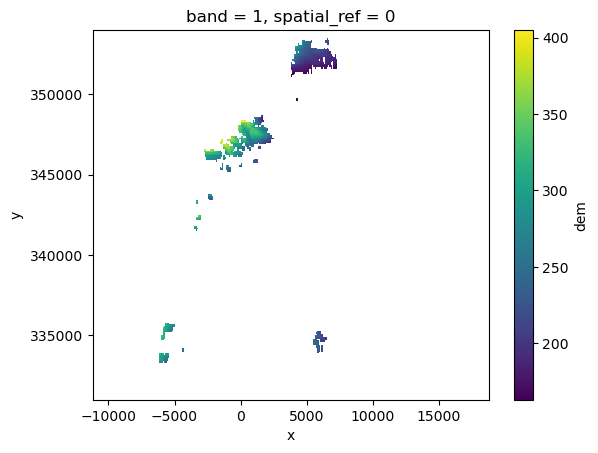

In [251]:
masked_dem['dem'].plot()

## Merge spatiotemporal and thematic data cubes